[colab](https://colab.research.google.com/github/rufous86/studies/blob/main/DLS_NLP/05_language_modeling/hw_language_modelling.ipynb)

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы. 

В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [30]:
!pip install datasets -q

Импорт необходимых библиотек

In [31]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords

from collections import Counter
from typing import List

import string


import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['lines.linewidth'] = 1

In [32]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [34]:
# Загрузим датасет
dataset = load_dataset('imdb')

  0%|          | 0/3 [00:00<?, ?it/s]

In [35]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать: 

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером. 
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```. 
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [36]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
for sentence in tqdm(dataset['train']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence) if len(x) < word_threshold]
    )

  0%|          | 0/25000 [00:00<?, ?it/s]

In [37]:
print("Всего предложений:", len(sentences))

Всего предложений: 28827


Посчитаем для каждого слова его встречаемость.

In [38]:
def count_words(dataset, remove_stops=False):
    words = Counter()
    if remove_stops:
        stops = stopwords.words('english')
    else:
        stops = []

    # Расчет встречаемости слов
    for example in tqdm(dataset):
        # Приводим к нижнему регистру и убираем пунктуацию
        processed_text = example.lower().translate(
            str.maketrans('', '', string.punctuation))
        processed_text = [
            word for word in word_tokenize(processed_text)
                        if word not in stops
        ]

        for word in processed_text:
            words[word] += 1
    return words

words = count_words(dataset['train']['text'], remove_stops=False)

  0%|          | 0/25000 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [39]:
vocab_size = 40000

vocab = set(dict(sorted(words.items(), key=lambda x: x[1], reverse=True)[:vocab_size]).keys())
for serv_word in ['<unk>', '<bos>', '<eos>', '<pad>']:
    vocab.add(serv_word)

In [40]:
assert '<unk>' in vocab
assert '<bos>' in vocab 
assert '<eos>' in vocab 
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [41]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов). 

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```. 

In [42]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [43]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        # Допишите код здесь
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in self.data[idx]]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [44]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)
    
    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [45]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве. 

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации. 
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве. 

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [46]:
def evaluate(model, criterion, dataloader) -> tuple[float, float]:
    model.eval()
    perplexity = []
    losses = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f'Validation'):
            logits = model(batch['input_ids'].flatten(start_dim=0, end_dim=1)) # Посчитайте логиты предсказаний следующих слов
            loss = criterion(logits, batch['target_ids'].flatten()).cpu().detach()
            perplexity.append(torch.exp(loss).item())
            losses.append(loss)
    
    perplexity = sum(perplexity) / len(perplexity)
    loss = sum(losses) / len(losses)

    return perplexity, loss.item()

### Train loop (1 балл)

Напишите функцию для обучения модели. 

In [47]:
def train_model(model, 
                train_dataloader, 
                val_dataloader, 
                criterion, 
                optimizer, 
                num_epoch = 10) -> dict:
    # Напишите код здесь
    losses = []
    perplexities = []
    val_losses = []
    val_perplexities = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'].flatten(start_dim=0, end_dim=1))
            loss = criterion(
                logits, batch['target_ids'].flatten())
            
            perplexity = torch.exp(loss).item()
            perplexities.append(perplexity)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
        print('train_loss:', losses[-1])
        print('train_perplexity:', perplexities[-1])
            
        val_perplexity, val_loss = evaluate(model, criterion, val_dataloader)
        val_losses.append(val_loss)
        val_perplexities.append(val_perplexity)
        
        print('val_loss:', val_losses[-1])
        print('val_perplexity:', val_perplexities[-1])

    history = {
        'train_loss': losses,
        'train_perplexity': perplexities,
        'val_loss': val_losses,
        'val_perplexity': val_perplexities
        }
    return history

Функция для вывода графиков

In [48]:
def plot_result(history, model_name):
    print(model_name)
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'][1:], c='r', label='train')
    plt.plot(history['val_loss'][1:], c='b', label='val')
    plt.legend()
    plt.title(f'loss, best on val {min(history["val_loss"]):.5f}')

    plt.subplot(1, 2, 2)
    plt.plot(history['train_perplexity'][1:], c='r', label='train')
    plt.plot(history['val_perplexity'][1:], c='b', label='val')
    plt.legend()
    plt.title(f'perplexity, best on val {min(history["val_perplexity"]):.5f}')
    
    plt.show()

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её. 

In [49]:
class LanguageModelLinear(nn.Module):
    def __init__(
        self, embed_dim: int, 
        hidden_dim: int, 
        vocab_size: int,
        num_layers: int,
        gru_is_bidirectional: bool):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.GRU(embed_dim, 
                          hidden_dim, 
                          num_layers, 
                          bidirectional=gru_is_bidirectional,
                          batch_first=True)
        
        if gru_is_bidirectional:
            self.linear = nn.Linear(hidden_dim*2, hidden_dim)
        else:
            self.linear = nn.Linear(hidden_dim, hidden_dim)

        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        x, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim] 
        x = self.dropout(self.linear(self.non_lin(x)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(x))  # [batch_size, num_classes]

        return prediction

In [50]:
# Обучите модель здесь
model = LanguageModelLinear(embed_dim=256, 
                            hidden_dim=256, 
                            vocab_size=len(vocab),
                            num_layers=1,
                            gru_is_bidirectional=False).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history1 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.2358360158804373
train_perplexity: 14.845013618469238


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.6071555614471436
val_perplexity: 13.563530086416058


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.5061153311755775
train_perplexity: 12.55942153930664


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.3904030323028564
val_perplexity: 10.920899880670868


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.3364825433130423
train_perplexity: 10.775544166564941


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.2350716590881348
val_perplexity: 9.350029523393749


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.175465515305324
train_perplexity: 9.362215042114258


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.0701229572296143
val_perplexity: 7.929181774105646


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.032738049385956
train_perplexity: 8.344616889953613


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.9421236515045166
val_perplexity: 6.9773691270203715


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.9260528344475762
train_perplexity: 7.5999321937561035


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.8490102291107178
val_perplexity: 6.357836491238754


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.8479400965390285
train_perplexity: 7.022403717041016


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.7795917987823486
val_perplexity: 5.932188607950126


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.7879987698233588
train_perplexity: 6.674170017242432


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.724381685256958
val_perplexity: 5.613711032192264


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.7394983030814493
train_perplexity: 6.331308364868164


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.6815438270568848
val_perplexity: 5.378550896602395


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.6943423398950481
train_perplexity: 6.109382629394531


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.6376829147338867
val_perplexity: 5.147986082904107


Попробуем увеличить количество скрытых слоев

In [51]:
model = LanguageModelLinear(embed_dim=256, 
                            hidden_dim=256, 
                            vocab_size=len(vocab),
                            num_layers=2,
                            gru_is_bidirectional=False).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history2 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.3138676954237796
train_perplexity: 18.747211456298828


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.8948745727539062
val_perplexity: 18.084559195864518


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.887760788037632
train_perplexity: 18.101016998291016


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.841738224029541
val_perplexity: 17.148822143014552


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.775283581644132
train_perplexity: 16.00760841369629


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.7061190605163574
val_perplexity: 14.974150488861895


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.6648915538471707
train_perplexity: 14.335761070251465


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.608534097671509
val_perplexity: 13.582002884518785


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.5382621551745506
train_perplexity: 12.310220718383789


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.403501510620117
val_perplexity: 11.064885266059267


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.3173408218510243
train_perplexity: 9.722735404968262


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.1668736934661865
val_perplexity: 8.734996584664405


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.0600149973979973
train_perplexity: 7.639966011047363


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.9004275798797607
val_perplexity: 6.693201719132145


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.8354328126538524
train_perplexity: 5.974210262298584


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.692722201347351
val_perplexity: 5.438898681539349


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.649991291662606
train_perplexity: 4.806227684020996


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.5431207418441772
val_perplexity: 4.6836992238475155


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.5348193079068515
train_perplexity: 4.163809776306152


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.456264615058899
val_perplexity: 4.29426788228803


Попробуем Bidirectional GRU с 2 скрытыми слоями

In [52]:
# Обучите модель здесь
model = LanguageModelLinear(embed_dim=256, 
                            hidden_dim=256, 
                            vocab_size=len(vocab),
                            num_layers=2,
                            gru_is_bidirectional=True).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history3 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.7791446282718724
train_perplexity: 5.647071361541748


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.606111764907837
val_perplexity: 4.984305499929242


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.6860270025157138
train_perplexity: 1.1097581386566162


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.0741531103849411
val_perplexity: 1.0769933799726774


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.04442347193044194
train_perplexity: 1.0175106525421143


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.009672620333731174
val_perplexity: 1.0097204119758267


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.012205495604555746
train_perplexity: 1.00753915309906


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.0035448537673801184
val_perplexity: 1.0035513238569276


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.006130199326274309
train_perplexity: 1.0045875310897827


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.0018836488015949726
val_perplexity: 1.0018855153986839


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.0037894053114526675
train_perplexity: 1.0029832124710083


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.0011466824216768146
val_perplexity: 1.0011473672579876


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.0026068063838746995
train_perplexity: 1.0020289421081543


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.0007814134587533772
val_perplexity: 1.0007817386525921


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.0019035922158869673
train_perplexity: 1.0015596151351929


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.0005522099672816694
val_perplexity: 1.0005523673201029


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.001447831730111322
train_perplexity: 1.001249074935913


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.00040873585385270417
val_perplexity: 1.0004088161265956


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.001138934764614874
train_perplexity: 1.0009009838104248


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.000314486853312701
val_perplexity: 1.0003145374028029


### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше. 

Попробуем в первой модели с 1 слоем скрытого состояния и однонаправленным GRU добавить сверточный слой перед GRU

In [53]:
class LanguageModelConvBeforeGRU(nn.Module):
    def __init__(self, vocab_size: int, 
                 embed_dim: int, 
                 hidden_dim: int, 
                 kernel_size: int,
                 b_norm: bool):
        super().__init__()
        self.b_norm = b_norm
        self.norm = nn.BatchNorm1d(hidden_dim)

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv = nn.Conv1d(embed_dim, hidden_dim, kernel_size, padding='same')
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(0)
        x = x.permute(0, 2, 1) # swap dimensions for Conv1d
        x = self.conv(x)
        x = nn.functional.relu(x)

        if self.b_norm:
            x = self.norm(x)

        x = x.permute(0, 2, 1) # swap dimensions back
        x = x.squeeze(0)
        x, _ = self.gru(x)
        x = self.fc(x)
        return x


In [54]:
model = LanguageModelConvBeforeGRU(embed_dim=256, 
                          hidden_dim=256, 
                          vocab_size=len(vocab),
                          kernel_size=3,
                          b_norm=False).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history4 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.8729398440240331
train_perplexity: 1.0203667879104614


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.020926756784319878
val_perplexity: 1.0211479020329703


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.01150811292508936
train_perplexity: 1.0064705610275269


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.006637789309024811
val_perplexity: 1.0066599318411498


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.004780890313311588
train_perplexity: 1.0033950805664062


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.0034605979453772306
val_perplexity: 1.00346659981044


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.0027590371032878347
train_perplexity: 1.0021426677703857


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.0021684360690414906
val_perplexity: 1.002170792723124


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.0017847248079069988
train_perplexity: 1.0014415979385376


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.0014563269214704633
val_perplexity: 1.00145738947708


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.0012438841368642877
train_perplexity: 1.0010583400726318


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.0010646008886396885
val_perplexity: 1.0010651677055697


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.0009361881944762533
train_perplexity: 1.0008172988891602


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.000822903704829514
val_perplexity: 1.000823239309598


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.0007367178084436825
train_perplexity: 1.0006529092788696


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.0006574744475074112
val_perplexity: 1.0006576934746936


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.0005946349103688083
train_perplexity: 1.000532865524292


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.0005366437835618854
val_perplexity: 1.0005367836066053


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.0004893487698182423
train_perplexity: 1.000442385673523


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.0004453589499462396
val_perplexity: 1.0004454555764664


Добавим слой батч нормализации после сверток

In [55]:
model = LanguageModelConvBeforeGRU(embed_dim=256, 
                          hidden_dim=256, 
                          vocab_size=len(vocab),
                          kernel_size=3,
                          b_norm=True).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history5 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.6581305061539028
train_perplexity: 1.0058034658432007


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.005667685065418482
val_perplexity: 1.00568403923406


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.0034180554331059037
train_perplexity: 1.002094030380249


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.002006299328058958
val_perplexity: 1.002008346329748


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.0015267889273934355
train_perplexity: 1.0011475086212158


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.0010902852518483996
val_perplexity: 1.001090878933932


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.0008944212217835802
train_perplexity: 1.000741958618164


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.0007020543562248349
val_perplexity: 1.0007023062326212


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.0005965244624112831
train_perplexity: 1.0005230903625488


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.000494986365083605
val_perplexity: 1.0004951131027358


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.00043180615233401483
train_perplexity: 1.0003905296325684


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.00036952851223759353
val_perplexity: 1.0003695973252829


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.00032800967832101067
train_perplexity: 1.0003025531768799


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.0002862634137272835
val_perplexity: 1.0002863027353202


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.00025775875009915366
train_perplexity: 1.0002411603927612


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.00022842924227006733
val_perplexity: 1.0002284566913031


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.0002076986819204684
train_perplexity: 1.0001964569091797


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.00018596381414681673
val_perplexity: 1.00018598442584


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.00017047357872174797
train_perplexity: 1.0001627206802368


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.00015404264559037983
val_perplexity: 1.0001540521604826


Language Model Linear с 1 GRU слоем


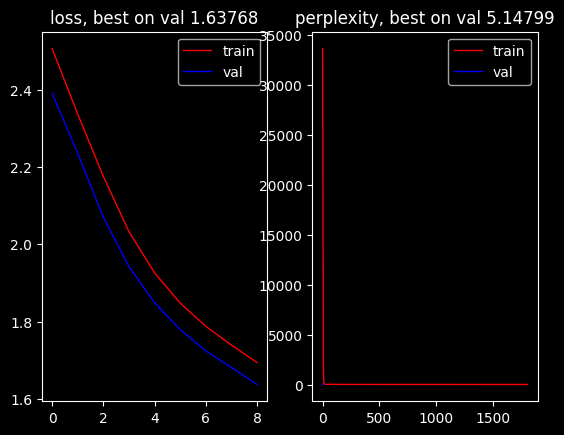

Language Model Linear с 2 GRU слоями


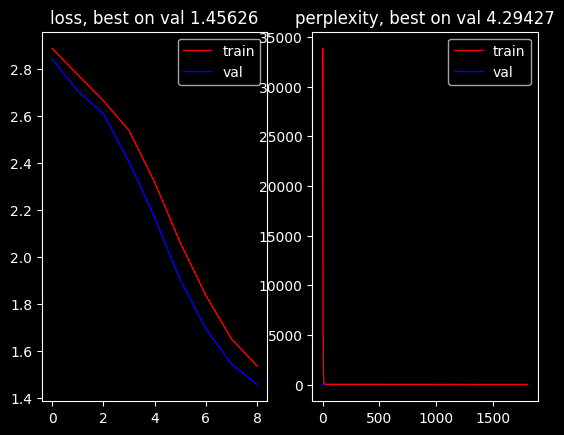

Language Model Linear с 2 Bidirectional GRU слоями


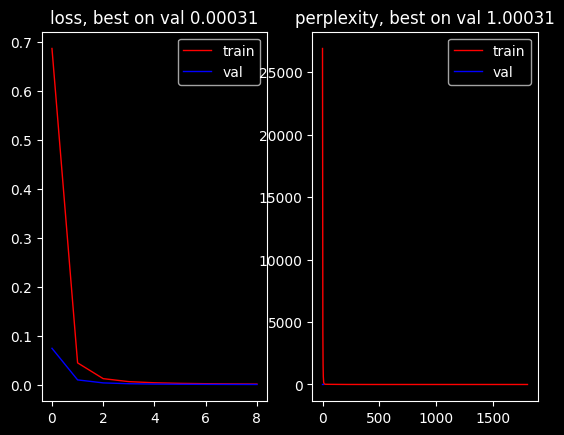

Language Model Conv Before GRU


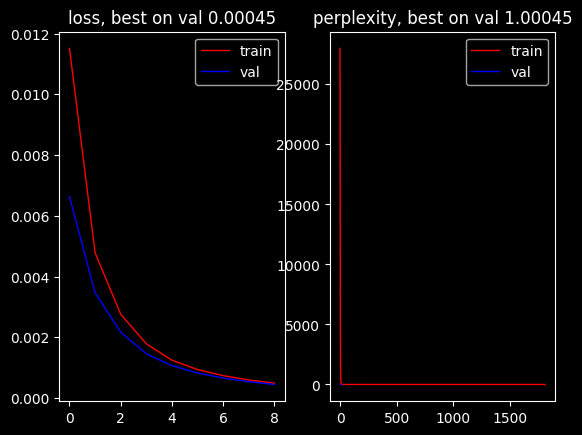

Language Model Conv Before GRU с батч нормализацией


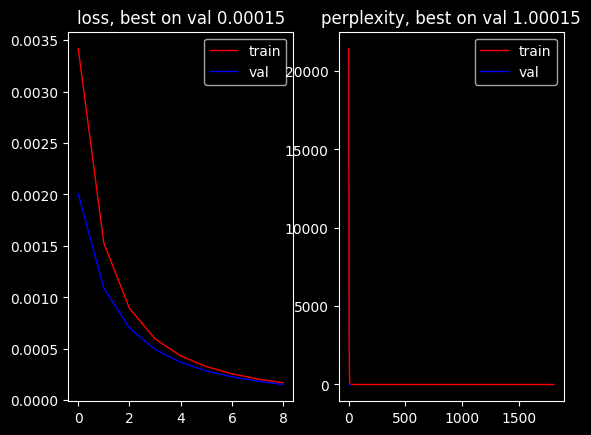

In [58]:
plot_result(history1, 'Language Model Linear с 1 GRU слоем')
plot_result(history2, 'Language Model Linear с 2 GRU слоями')
plot_result(history3, 'Language Model Linear с 2 Bidirectional GRU слоями')
plot_result(history4, 'Language Model Conv Before GRU')
plot_result(history5, 'Language Model Conv Before GRU с батч нормализацией')

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей. 

In [83]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 32) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_word_distribution = model(input_ids)[-1]
            next_word = next_word_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind['<eos>']:
                break
    
    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words

generate_sequence(model, starting_seq='i play some')

'<bos> i play some 0 <eos>'